In [1]:
# %% Cell 1 — (Optional) Install light NLP tools (only if not available)
# We avoid reinstalling pandas/numpy to prevent dependency conflicts.
!pip install --quiet nltk


In [2]:
# %% Cell 2 — NLTK downloads (run once)
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# %% Cell 3 — Imports (keep these; already available in Colab)
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import joblib


In [4]:
# %% Cell 4 — Load dataset (use your path)
DATA_PATH = "/content/synthetic_bank_tweets_1500_with_names.csv"
df = pd.read_csv(DATA_PATH).reset_index(drop=True)
print("Loaded:", df.shape)
display(df.head(3))


Loaded: (1500, 16)


user_name       bank_name bank_type platform            timestamp  \
0    Manish       Axis Bank   Private  Twitter  2024-09-02T13:54:18   
1   Keerthi  Bank of Baroda    Public  Twitter  2025-11-02T21:48:45   
2      Amit      ICICI Bank   Private  Twitter  2025-10-15T04:53:45   

                                                text   category  \
0  Axis Bank offered helpful service at the branc...    service   
1  Can't complete payment on Bank of Baroda. UPI ...    failure   
2  Claimed an offer from ICICI Bank and it worked...  promotion   

   sentiment_score sentiment  likes  retweets  user_followers  is_reply  \
0           -0.194  negative      1         0            7640     False   
1           -0.439  negative      6         0           15511      True   
2            0.702  positive      3         0           18699     False   

   in_reply_to_bank_response  response_time_minutes          location  
0                       True                   70.0      Delhi, India  
1                       True                    5.0  Hyderabad, India  
2                       True                  120.0    Kolkata, India

In [5]:
# %% Cell 5 — Prepare labels (ensure we have the target classes)
# We'll use the 'category' column if available. If 'fraud' is missing, we'll derive it using keywords.
df['category'] = df['category'].astype(str).str.lower()

# create a fraud label from text keywords if 'fraud' does not exist in categories
if 'fraud' not in df['category'].unique():
    fraud_kw = ['fraud','scam','phish','phishing','unauthorised','unauthorized','hacked','hack','theft','chargeback','unauth']
    df['category'] = df.apply(lambda r: 'fraud' if any(kw in str(r['text']).lower() for kw in fraud_kw) else r['category'], axis=1)

# target classes we want to model
target_classes = ['failure','service','promotion','fraud']

# Filter rows where category is one of the target classes
df_ml = df[df['category'].isin(target_classes)].copy()
print("Filtered dataset shape (only target classes):", df_ml.shape)
display(df_ml['category'].value_counts())


Filtered dataset shape (only target classes): (1200, 16)


category
failure      417
service      365
promotion    264
fraud        154
Name: count, dtype: int64

In [7]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# %% Cell 6 — Basic preprocessing function (clean + lemmatize)
lemmatizer = WordNetLemmatizer()
stopwords = set(nltk.corpus.stopwords.words('english'))

def preprocess_text(text):
    if pd.isna(text):
        return ""
    s = str(text).lower()
    s = re.sub(r'http\S+|www\S+', ' ', s)     # remove urls
    s = re.sub(r'@\w+|#\w+', ' ', s)          # remove mentions/hashtags
    s = re.sub(r'[^a-z0-9\s₹]', ' ', s)       # keep alphanum and rupee symbol if present
    tokens = word_tokenize(s)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if len(t) > 2 and t not in stopwords]
    return " ".join(tokens)

# Apply preprocessing (safe assignment)
df_ml['text_clean'] = df_ml['text'].astype(str).apply(preprocess_text)
display(df_ml[['text','text_clean','category']].head(6))


text  \
0  Axis Bank offered helpful service at the branc...   
1  Can't complete payment on Bank of Baroda. UPI ...   
2  Claimed an offer from ICICI Bank and it worked...   
3  Axis Bank customer service resolved my issue q...   
4  Loving the cashback offer on SBI app today! #D...   
5  Transaction failed on HDFC Bank UPI — money de...   

                                          text_clean   category  
0    axis bank offered helpful service branch online    service  
1  complete payment bank baroda upi timeout happened    failure  
2         claimed offer icici bank worked seamlessly  promotion  
3  axis bank customer service resolved issue quic...    service  
4                loving cashback offer sbi app today  promotion  
5  transaction failed hdfc bank upi money debited...    failure

In [9]:
# %% Cell 7 — Train/test split (stratified)
X = df_ml['text_clean'].values
y = df_ml['category'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", len(X_train), "Test:", len(X_test))


Train: 960 Test: 240


In [10]:
# %% Cell 8 — TF-IDF vectorization
# Keep a reproducible, reasonably sized vectorizer
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)


TF-IDF shapes: (960, 323) (240, 323)


In [12]:
# %% Cell 9 — Train a baseline classifier (Logistic Regression)
clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", round(f1_score(y_test, y_pred, average='macro'), 4))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))


Accuracy: 1.0
Macro F1: 1.0

Classification Report:

              precision    recall  f1-score   support

     failure     1.0000    1.0000    1.0000        83
       fraud     1.0000    1.0000    1.0000        31
   promotion     1.0000    1.0000    1.0000        53
     service     1.0000    1.0000    1.0000        73

    accuracy                         1.0000       240
   macro avg     1.0000    1.0000    1.0000       240
weighted avg     1.0000    1.0000    1.0000       240



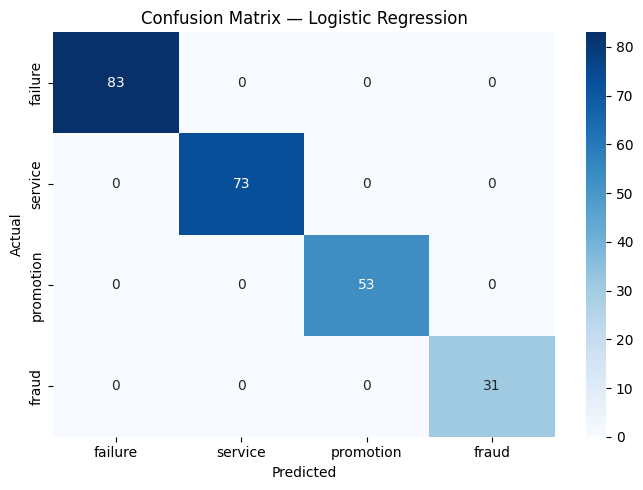

In [13]:
# %% Cell 10 — Confusion matrix (visual)
cm = confusion_matrix(y_test, y_pred, labels=target_classes)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_classes, yticklabels=target_classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Logistic Regression")
plt.tight_layout()
plt.show()


In [15]:
# %% Cell 11 —  Try MultinomialNB and compare
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_nb = nb.predict(X_test_tfidf)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_nb))
print("Naive Bayes Macro F1:", round(f1_score(y_test, y_nb, average='macro'), 4))
print(classification_report(y_test, y_nb, digits=4))


Naive Bayes Accuracy: 1.0
Naive Bayes Macro F1: 1.0
              precision    recall  f1-score   support

     failure     1.0000    1.0000    1.0000        83
       fraud     1.0000    1.0000    1.0000        31
   promotion     1.0000    1.0000    1.0000        53
     service     1.0000    1.0000    1.0000        73

    accuracy                         1.0000       240
   macro avg     1.0000    1.0000    1.0000       240
weighted avg     1.0000    1.0000    1.0000       240



In [17]:
# %% Cell 12 —  Quick hyperparameter tuning for LogisticRegression (small grid)
# This is optional and may take several minutes depending on data size. Use StratifiedKFold.
param_grid = {
    'C': [0.1, 1.0, 5.0],
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
                    param_grid, cv=cv, scoring='f1_macro', n_jobs=2, verbose=0)
grid.fit(X_train_tfidf, y_train)
print("Best params:", grid.best_params_)
best = grid.best_estimator_
y_best = best.predict(X_test_tfidf)
print("Tuned Accuracy:", accuracy_score(y_test, y_best))
print("Tuned Macro F1:", round(f1_score(y_test, y_best, average='macro'), 4))



Best params: {'C': 0.1}
Tuned Accuracy: 1.0
Tuned Macro F1: 1.0


In [19]:
# %% Cell 14 — Example: predict on new text (quick demo)
examples = [
    "My UPI transaction failed and money debited but not credited.",
    "Loved the new cashback offer from ICICI, got ₹100!",
    "Customer care hasn't responded for 3 days",
    "I received a suspicious message about unauthorized transfer"
]
examples_clean = [preprocess_text for preprocess_text in map(preprocess_text, examples)]
X_ex = tfidf.transform(examples_clean)
print("Examples:", examples)
print("Predictions:", clf.predict(X_ex))


Examples: ['My UPI transaction failed and money debited but not credited.', 'Loved the new cashback offer from ICICI, got ₹100!', "Customer care hasn't responded for 3 days", 'I received a suspicious message about unauthorized transfer']
Predictions: ['failure' 'promotion' 'fraud' 'fraud']
